# Infer **`Endoplasmic Reticulum (ER)`**

***Prior to this notebook, you should have already run through [1.0_image_setup](1.0_image_setup.ipynb).***

In notebooks 1.2 through 1.7, we will go over the implementation of `infer-subc` in the a Napari plugin called  `organelle-segmenter-plugin`. The steps outlined in each notebook correlate to the workflow steps from the plugin. Here, you will gain knownledge of what `infer-subc` functions are involved in each of those steps. 

The segmentation workflows are completely independent of each other and can be run in any order. The current notebook segments the `ER`. Notebooks for the segmentation of other organelles can be found here:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)

***Note:** These notebooks do not include a batch processing option. They are simply explanations of the steps included in the Napari plugin. If you would like to batch process your images in a Jupyter notebook instead of the plugin, you can use the [batch process segmentation](batch_process_segmentations.ipynb) notebook.*

### **Single cell analysis**
Each workflow segments organelles from the entire image, irrespective of the cell mask identified in notebook 1.1. To attain a single-cell analysis, the mask will be applied to the organelle segmentation outputs before quantification in the `part_2_quantification` notebooks. 

### **ER** 🕸️
The endoplasmic reticulum (ER) is the primary site of protein and lipid synthesis in the cell. It also plays a major role in the organization, trafficking, and regulation of other membrane-bound organelles through ER membrane contact sites. The ER is usually composed of one continuous network of tubules and membrane sheets, but can, under certain conditions, fragment into separate networks. 

⚠️ ***IMPORTANT: In this workflow, the ER is labeled as one object, even if there are regions of the ER separate from each other.***

### **Fluorescence labeling strategies** 🔆 
The ER can be fluorescently labeled in live and fixed cells by staining for endogenous proteins, targeting fluorescent proteins to the membrane or lumen using genetically encoded markers, or with dye-based approaches. The labeling approach used and resolution of your images can result in different staining outcomes that can impact the segmentation steps below. This is particularly important when trying to segment fine ER tubule structures. Higher resultion imaging or deconvolution may be beneficial to improve the segmentation outcomes.

This workflow was optimized for images of fluorescently tagged Sec61-beta, a membrane protein. The fluorophore is localized to the luminal side of the ER in an effort to reduce overestimation of the the fine tubular structures that may occurring with a cytoplasmic facing tag. We have opted to include a two step segmentation method to segment the bulk of the ER using a combined global and local thresholding method as well as a method that focuses on tubular structures.

***We advise that you test the segmentation process on a small, pilot dataset before committing to a particular labeling strategy and segmentation approach.***

-----

### 👣 **Summary of steps**  

➡️ **EXTRACTION**
- **`STEP 1`** - Select a channel for segmentation

    - select single channel containing the ER marker (channel number = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE-PROCESSING**
- **`STEP 3`** - Global + local thresholding (AICSSeg – MO)

    - apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

- **`STEP 4`** - ‘Filament’ threshold method (AICSSeg)

  - apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

- **`STEP 5`** - Combine Segmentations (logical or)

  - combine the two segmentations with logical *OR*

**POST-PROCESSING**
- **`STEP 6`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 7`** - Create one object (as unt16)

  - label all ER "objects" 1/True

**EXPORT** ➡️ 
- save labeled ***ER*** (ER) as unsigned integer 16-bit tif files


*The Allen Cell Segmenter procedure included an edge proserving smoothing method followed by the "filament" thresholding method (find the Sec61b script [here](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/structure_wrapper/seg_sec61b.py)). We have opted to exclude the edge preserving smoothing method and also include to MO threshold method as it segments densely packed ER better*

---------------------
## **IMPORTS AND LOAD IMAGE**
Details about the functions included in this subsection are outlined in the [`1.0_image_setup`](1.0_image_setup.ipynb) notebook. Please visit that notebook first if you are confused about any of the code included here.

#### &#x1F3C3; **Run code; no user input required**

In [21]:
# top level imports
from pathlib import Path
import os

import numpy as np
import pandas as pd
import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files)
from infer_subc.core.img import *
 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information about your data: `im_type`, `data_root_path`, `in_data_path`, and `out_data_path`.

In [22]:
#### USER INPUT REQUIRED ###
im_type = ".czi"
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"
in_data_path = data_root_path / "raw"
out_data_path = data_root_path / "out"

#### &#x1F3C3; **Run code; no user input required**

In [23]:
# list files in the input folder
img_file_list = list_image_files(in_data_path,im_type)
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Image Name":img_file_list})

,Image Name
0,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\11252023_MSi08L_iPSCs_undiff_BR1_N20_Unmixing.czi
1,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_2_Unmixing.czi
2,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_3_Unmixing.czi
3,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_10_Unmixing.czi
4,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_4_Unmixing.czi
5,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
6,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_14_Unmixing.czi
7,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_01_Unmixing.czi
8,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_02_Unmixing.czi
9,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_07_Unmixing.czi


#### &#x1F6D1; &#x270D; **User Input Required:**

Use the list above to specify which image you wish to analyze based on its index: `test_img_n`

In [24]:
#### USER INPUT REQUIRED ###
test_img_n = 5

#### &#x1F3C3; **Run code; no user input required**

In [25]:
# load image and metadata
test_img_name = img_file_list[test_img_n]
img_data,meta_dict = read_czi_image(test_img_name)

# metadata
channel_names = meta_dict['name']
meta = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
file_path = meta_dict['file_name']
print("Metadata information")
print(f"File path: {file_path}")
for i in list(range(len(channel_names))):
    print(f"Channel {i} name: {channel_names[i]}")
print(f"Scale (ZYX): {scale}")
print(f"Channel axis: {channel_axis}")

# open viewer and add images
viewer = napari.Viewer()
for i in list(range(len(channel_names))):
    viewer.add_image(img_data[i],
                     scale=scale,
                     name=f"Channel {i}")
viewer.grid.enabled = True
viewer.reset_view()
print("\nProceed to Napari window to view your selected image.")

Metadata information
File path: C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
Channel 0 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Nuclei_Jan22
Channel 1 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Lyso+405_Jan22
Channel 2 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Mito+405_Jan22
Channel 3 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Golgi+405_Jan22
Channel 4 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Peroxy+405_Jan22
Channel 5 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: ER+405_Jan22
Channel 6 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: BODIPY+405low_Jan22
Channel 7 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Residuals
Scale (ZYX): (0.3891184878080979, 0.07987165184837317, 0.07987165184837318)
Channel axis: 0

Proceed to Napari window to view your selected image.


-----

## **EXTRACTION**

### **`STEP 1` - Select a channel for segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify which channel includes your ER label:
- `ER_CH`: the index of the channel containing your ER label. Image indexing begin with 0, not 1. Reference the channel numbers indicated in the Napari window for easy reference.

In [26]:
#### USER INPUT REQUIRED ###
ER_CH = 5

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block extracts the ER channel from your multi- (or single) channel image. It will be the only part of the image used in the rest of this workflow. The single mitochondria channel is added to the Napari viewer.

In [27]:
# select channel
raw_ER = select_channel_from_raw(img_data, ER_CH)

# clear napari and add single channel as a new layer
viewer.layers.clear()
viewer.grid.enabled = False
viewer.add_image(raw_ER, scale=scale, name="1 - Extract ER")

<Image layer '1 - Extract ER' at 0x259137858a0>

-----
## **PRE-PROCESSING**

### **`STEP 2` - Rescale and smooth image**

&#x1F453; **FYI:** This code block rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0. The image is then *optionally* smoothed using a Gaussian and/or median filter. 

<mark> Include more information on the Gaussian and median filtering methods here </mark>

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount of filter to use for each method. Higher values indicate more smoothing:
- `med_filter_size`: the size of the median filter to apply; if 0 is used, no filter will be applied
- `gaussian_smoothing_sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied

In [28]:
#### USER INPUT REQUIRED ###
median_sz = 2
gauss_sig = 1

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block rescales the image and applies the specified median and Gaussian filters. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [29]:
# rescaling and smoothing input image
struct_img = scale_and_smooth(raw_ER,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)

# adding image to Napari as a new layer
viewer.add_image(struct_img, scale=scale, name="2 - Rescale and Smooth")

<Image layer '2 - Rescale and Smooth' at 0x25913d5b5b0>

-----
## **CORE-PROCESSING**

### **`STEP 3` - Global + local thresholding (AICSSeg – MO)**

&#x1F453; **FYI:** This code block is the first of two semantic segmentation steps that are combined together in a later step. `Semantic segmentation` is the process of deciding whether a pixel/voxel should be included in an object (labeled with a value of 1) or should be considered as part of the background (labeled with a value of 0). A semantic segmentation does not discern individual objects from one another.

The masked_object_filter utilizes the 'MO' filter from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. AICS documentation states: "The algorithm is a hybrid thresholding method combining two levels of thresholds. The steps are: [1] a global threshold is calculated, [2] extract each individual connected componet after applying the global threshold, [3] remove small objects, [4] within each remaining object, a local Otsu threshold is calculated and applied with an optional local threshold adjustment ratio (to make the segmentation more and less conservative). An extra check can be used in step [4], which requires the local Otsu threshold larger than 1/3 of global Otsu threhsold and otherwise this connected component is discarded."

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `thresh_method`: the global thresholding method; options include 'tri'/'triangle, 'med'/'median' or 'ave'/'ave_tri_med'. Triangle implements the [skimage.filters.threshold_triangle](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_triangle) method, median utilizes the 50th percentile of the intensities, and ave uses the average of the two methods to calculate the lower bound of the global threshold.
- `cell_wise_min_area`: the minimum expected size of your object; smaller objects will be removed prior to local thresholding
- `thresh_adj`: adjustment to make to the local threshold; larger values make the segmentation more stringent (less area included)

In [30]:
#### USER INPUT REQUIRED ###
thresh_method = 'tri'
cell_wise_min_area = 1200
thresh_adj = 0.7

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the MO filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed.

In [31]:
# segment the ER with this global and local thresholding method
bw_MO_test = masked_object_thresh(struct_img,
                          global_method=thresh_method, 
                          cutoff_size=cell_wise_min_area, 
                          local_adjust=thresh_adj)

# adding image to Napari as a new layer
viewer.add_image(bw_MO_test, scale=scale, name="3 - MO filter", opacity=0.3, colormap="cyan", blending='additive')

<Image layer '3 - MO filter' at 0x25913827970>

### **`STEP 4` - ‘Filament’ threshold method (AICSSeg)**

&#x1F453; **FYI:** This code block is the second semantic segmentation step that will be combined with the dot filter results.

The 'filament' filter is derived from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. It utilizes up to three scale (object size) and cutoff (threshold) pairs for objects of different size and intensity. This function is specifically designed to segment filamentous or tubular objects.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the scale and cutoff values for each pair:
- `fil_scale_1`: the size scale for the first scale/cutoff pair; larger values correlate to selection of larger objects
- `fil_cut_1`: the threshold cutoff value for the first scale/cutoff pair; small cutoffs tend to yield more dots that are larger in volume; larger cutoffs tend to yield less dots that are slimmer.
- `fil_scale_2`: the size scale for the second scale/cutoff pair; this can be set to 0 if a second scale/cutoff pair isn't needed
- `fil_cut_2`: the threshold cutoff value for the second scale/cutoff pair; this can be set to 0 if a second scale/cutoff pair isn't needed
- `fil_scale_3`: the size scale for the third scale/cutoff pair; this can be set to 0 if a third scale/cutoff pair isn't needed
- `fil_cut_3`: the threshold cutoff value for the third scale/cutoff pair; this can be set to 0 if a third scale/cutoff pair isn't needed
- `fil_method`: "3D" processes the image taking into account intensities in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering any intensity in higher or lower Z planes.

In [32]:
#### USER INPUT REQUIRED ###
fil_scale_1 = 1
fil_cut_1 = 0.007

fil_scale_2 = 2
fil_cut_2 = 0.007

fil_scale_3 = 0
fil_cut_3 = 0

fil_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the filament filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: it is helpful to adjust sellect the scale/cutoff filters one at a time and then combine them once each pair's settings are confirmed.*

In [33]:
# apply the 2D or 3D versions of the AICSsegmentation filament filter with multiple scales
bw_filament_test = filament_filter_3(struct_img,
                                    fil_scale_1,
                                    fil_cut_1,
                                    fil_scale_2,
                                    fil_cut_2,
                                    fil_scale_3,
                                    fil_cut_3,
                                    fil_method)

# adding image to Napari as a new layer
viewer.add_image(bw_filament_test, scale=scale, name="4 - Filament filter", opacity=0.3, colormap="magenta", blending='additive')

<Image layer '4 - Filament filter' at 0x25916e5c2b0>

### **`STEP 5` - Combine Segmentations**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block combines the dot and filament filter outputs together using the "logical or" operation. The resulting semantic segmentation can be viewed in Napari.

In [34]:
# combine the two segmentations together
bw_test = np.logical_or(bw_MO_test, bw_filament_test)

# adding image to Napari as a new layer
viewer.add_image(bw_test, scale=scale, name="5 - Combined Semantic Segmentation", colormap="green")

<Image layer '5 - Combined Semantic Segmentation' at 0x25913dfee30>

-----
## **POST-PROCESSING**

### **`STEP 6` - Remove small holes and objects**

&#x1F453; **FYI:** This code block cleans up the semantic segmentation by filling small holes and/or removing small objects that can be considered errors in the initial segmentation. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

In [36]:
#### USER INPUT REQUIRED ###
hole_min_width = 0
hole_max_width = 0

small_object_width = 4

fill_filter_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block fills small holes and removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: white pixels/voxels are the ones remaining after this step*

In [37]:
# fill holes and removed small objects
cleaned_img2 = fill_and_filter_linear_size(bw_test, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# adding image to Napari as a new layer
viewer.add_image(cleaned_img2, scale=scale, name="6 - Fill holes and remove small objects", colormap="magenta", blending="additive")

<Image layer '6 - Fill holes and remove small objects' at 0x25982787700>

-----
## **POST-POST-PROCESSING**

## **`STEP 7` - Label objects**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block created a 16-bit binary image where all ER objects are assigned the value of 1. This step is included because we are assuming that the ER is one continuous network.

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color. You should only see one colored object.*

In [38]:
# create binary image
ER_labels = label_bool_as_uint16(cleaned_img2)

# adding image to Napari as a new layer
viewer.add_labels(ER_labels, scale=scale, name="7 - Instance segmentation")

<Labels layer '7 - Instance segmentation' at 0x25916b94940>

-----
## **SAVING**

## **`Saving` - Save the segmentation output**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block saves the instance segmentation output to the `out_data_path` specified earlier.

In [39]:
# Saving file
out_file_n = export_inferred_organelle(ER_labels, "ER", meta_dict, out_data_path)
print(f"saved to: {out_data_path}")

saved file: a24hrs-Ctrl_10_Unmixing-ER
saved to: C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out


-----
-----
## **Define `infer_ER()` function**
The following code includes an example of how the workflow steps above are combined into one function. This function can be run below to process a single image. It is included in the [batch process notebook](batch_process_segmentations.ipynb) to run the above analysis on multiple cells. 

This function can utilized from infer-subc using: 
```python
infer_subc.organelles.er.infer_ER()
```

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_ER()` function. It is applied below.

In [40]:
##########################
#  infer_ER
##########################
def _infer_ER(
              in_img: np.ndarray,
              ER_ch: int,
              median_sz: int,
              gauss_sig: float,
              MO_thresh_method: str,
              MO_cutoff_size: float,
              MO_thresh_adj: float,
              fil_scale_1: float,
              fil_cut_1: float,
              fil_scale_2: float, 
              fil_cut_2: float, 
              fil_scale_3: float, 
              fil_cut_3: float,
              fil_method: str,
              min_hole_w: int,
              max_hole_w: int,
              small_obj_w: int,
              fill_filter_method: str
              ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    filament_scale: 
        scale (log_sigma) for filament filter
    filament_cut: 
        threshold for filament fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # EXTRACT
    ###################    
    ER = select_channel_from_raw(in_img, ER_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    # er = normalized_edge_preserving_smoothing(er)
    struct_img =  scale_and_smooth(ER,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)

    ###################
    # CORE_PROCESSING
    ###################
    bw1 = masked_object_thresh(struct_img, 
                                    global_method=MO_thresh_method, 
                                    cutoff_size=MO_cutoff_size, 
                                    local_adjust=MO_thresh_adj)

    bw2 = filament_filter_3(struct_img, fil_scale_1, fil_cut_1, fil_scale_2, fil_cut_2, fil_scale_3, fil_cut_3, fil_method)

    struct_obj = np.logical_or(bw1, bw2)
    
    ###################
    # POST_PROCESSING
    ################### 
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    
    # ENSURE THAT there is ONLY ONE ER
    struct_obj = label_bool_as_uint16(struct_obj)

    return struct_obj 

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

The segmentation output here matches the output created above: True


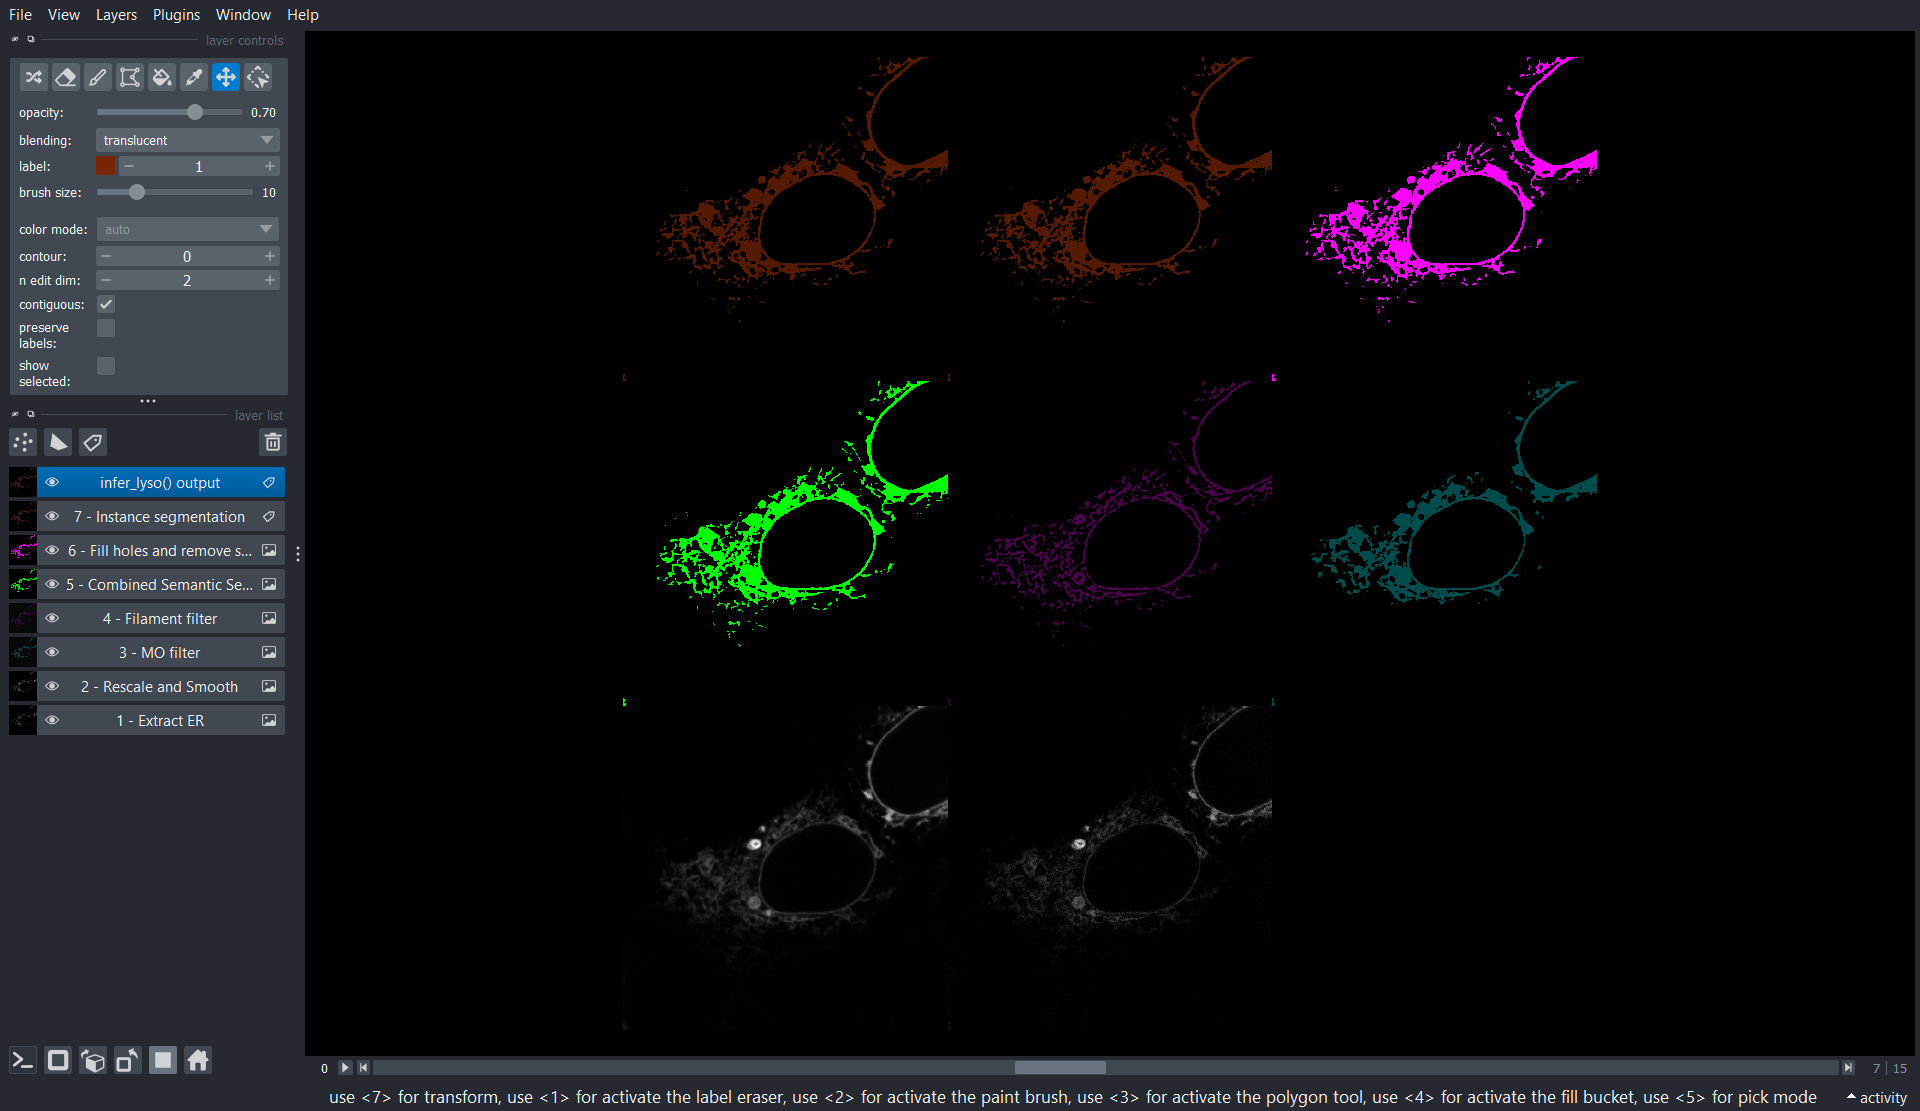

In [41]:
_ER_object =  _infer_ER(
        img_data,
        ER_CH,
        median_sz,
        gauss_sig,
        thresh_method,
        cell_wise_min_area,
        thresh_adj,
        fil_scale_1,
        fil_cut_1,
        fil_scale_2,
        fil_cut_2,
        fil_scale_3,
        fil_cut_3,
        fil_method,
        hole_min_width,
        hole_max_width,
        small_object_width,
        fill_filter_method)

#confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(ER_labels == _ER_object)}")

# adding image to Napari as a new layer
viewer.add_labels(_ER_object, scale=scale, name="infer_lyso() output")
viewer.grid.enabled = True
viewer.reset_view()

# screenshot viewer
nbscreenshot(viewer, canvas_only = False)

-------------
### ✅ **INFER ER COMPLETE!**

Continue on to other notebooks as needed:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)

Or proceed to batch processing here: [batch process notebook](batch_process_segmentations.ipynb)